In [2]:
# for reload python packages under development
%load_ext autoreload
%autoreload 2

# if add new modules, then do
# %reload_ext autoreload
# %autoreload 2    

In [3]:
import os, pytest

# Optional: set CWD to your package root so relative paths work
package_dir = "/home/lel2/luan/projects/cell_tissue_phenotype/tools/regression/tests/"

# Single test function
# pytest.main([package_dir + "test_compositional_ilr.py::test_transform_matches_manual_pipeline", "-q"])

# Whole file
pytest.main([package_dir + "test_compositional_ilr.py", "-q"])

# See prints during the test
# pytest.main([package_dir + "test_compositional_ilr.py::test_transform_matches_manual_pipeline", "-s", "-vv"])

....                                                                     [100%]
=============================== warnings summary ===============================
tests/test_compositional_ilr.py::test_transform_matches_manual_pipeline
  /data1/soldatr/luan/projects/cell_tissue_phenotype/uv_env/.venv/lib/python3.11/site-packages/skbio/util/_warning.py:40: DeprecationWarning: `multiplicative_replacement` was renamed to `multi_replace` in 0.6.0. The old name is kept as an alias but is deprecated.
    warn(message, warning)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
4 passed, 1 warning in 1.53s


<ExitCode.OK: 0>

## use refined data

In [5]:
# this uses data from 
# /home/lel2/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/refined/max_counts/mean_gene_expression
from regression.estimators import RidgeRRR, RidgeRRRCV, RRRBinEvaluator
from regression.preprocessing import CompositionalILR, StandardScalerX, CenterY, TrainTestSplit
from regression.checkfitting import CheckFitting

import torch
import numpy as np
import pandas as pd
from skbio.stats.composition import closure, multiplicative_replacement, ilr, ilr_inv, clr

# path_dir = "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/max_counts/parallel/mean_gene_expression_pseudobulk_"

# this path directory stores the pseudobulk mean gene expression of each cell type across samples
# obtained from running sbatch script_SLURM_mean_gene_expr.sh 
# check python script 4_EDA_celltype_gene_expr_pseudobulk_raw_counts.py and the corresponding notebook
path_dir = "/home/lel2/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/refined/max_counts/mean_gene_expression/mean_gene_expression_pseudobulk_"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 1) Read CSVs; first column is an ID, so use it as index (equivalent to R's [, 2:ncol])
cell_type_1 = "HSC_MPP"
# cell_type_1 = "MEBEMP-L"

mean_gene_expr_df_HSC_MPP = pd.read_csv(
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/mean_gene_expression_harmony_sample_id.csv",
    path_dir + cell_type_1 + "_max_counts.csv",
    index_col=0
    )

cell_type_2 = "B"
# cell_type_2 = "NKT"

mean_gene_expr_df_B = pd.read_csv(
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/mean_gene_expression_harmony_sample_id.csv",
    path_dir + cell_type_2 + "_max_counts.csv",
    index_col=0
)

cell_type_proportions_df = pd.read_csv(
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/cell_type_proportions_harmony_sample_id.csv",
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/cell_type_proportions_harmony_sample_id_avg_pseudobulk.csv",
    "/home/lel2/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/refined/max_counts/mean_gene_expression/cell_type_proportions_pseudobulk_max_counts.csv",
    index_col=0
)

# meta =  pd.read_csv("/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/max_counts/parallel/metadata_samples_pseudobulk_max_counts.csv")
meta = pd.read_csv("/home/lel2/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/refined/max_counts/mean_gene_expression/metadata_samples_pseudobulk_max_counts.csv")

# check that the indices (sample IDs) are the same and in the same order
assert(np.all(mean_gene_expr_df_HSC_MPP.index == mean_gene_expr_df_B.index))
assert(np.all(mean_gene_expr_df_HSC_MPP.index == cell_type_proportions_df.index))
assert(np.all(mean_gene_expr_df_HSC_MPP.index == meta["sample_id"]))

# ilr-transform cell type proportions
ilr_tx = CompositionalILR(zero_replacement=True).fit(cell_type_proportions_df.values)
Y_imp_ilr = ilr_tx.transform(cell_type_proportions_df.values)  # replace your earlier line

# Covariates: sex (one-hot, drop_first) and ages
Z = pd.get_dummies(meta[['sex_src']], prefix='sex_src', drop_first=True)
Z['ages'] = meta['ages'].astype(float)
Z = Z.astype(float)
Z.index = meta.index  # align


# stem cells of HSC_MPP and B cells
# X_design = np.concatenate([mean_gene_expr_df_HSC_MPP.values.astype(np.float64),
#                            mean_gene_expr_df_B.values.astype(np.float64),
#                            Z.to_numpy()], axis=1)

# generate bins
train_test = TrainTestSplit(nfolds = 5, random_state = 0)





## use HSC_MPP gene expression profile

The hypothesis is that gene expression profile of stem cells carries information about the downstream cell types. The signals are strong and maintained across samples, thereby predicting cell type proportions from the gene expression profile is conducted here. 

In [6]:
# stem cells of HSC_MPP
X_design_HSC_MPP = np.concatenate([mean_gene_expr_df_HSC_MPP.values.astype(np.float64),
                           Z.to_numpy()], axis=1)

RRRB_HSC = RRRBinEvaluator(device)
# do for nfolds
metrics_by_bin_HSC = RRRB_HSC.evaluate(X_design = X_design_HSC_MPP,
                                       Y_ilr = Y_imp_ilr, 
                                       train_test = train_test,
                                       ilr_tx = ilr_tx,
                                       cell_type_proportions_df = cell_type_proportions_df)


Bin 1: rank=16, lambda=1778.3, MSE clr comp=0.4682
Bin 2: rank=16, lambda=1000, MSE clr comp=0.4566
Bin 3: rank=16, lambda=1000, MSE clr comp=0.3851
Bin 4: rank=16, lambda=316.23, MSE clr comp=0.4420
Bin 5: rank=16, lambda=1000, MSE clr comp=0.3930


## use the HSC_MPP and B gene expression profile

Adding B cells gene expression profile is to see whether B cells carry other information about their proportion.

In [8]:
cell_type_3 = cell_type_1 + "_" + cell_type_2

X_design_HSC_MPP_B = np.concatenate([mean_gene_expr_df_HSC_MPP.values.astype(np.float64),
                                     mean_gene_expr_df_B.values.astype(np.float64),
                                     Z.to_numpy()], axis=1)


RRRB_HSC_B = RRRBinEvaluator(device)
metrics_by_bin_HSC_MPP_B = RRRB_HSC_B.evaluate(X_design = X_design_HSC_MPP_B,
                                           Y_ilr = Y_imp_ilr, 
                                           train_test = train_test,
                                           ilr_tx = ilr_tx,
                                           cell_type_proportions_df = cell_type_proportions_df)



Bin 1: rank=16, lambda=562.34, MSE clr comp=0.4329
Bin 2: rank=16, lambda=177.83, MSE clr comp=0.3856
Bin 3: rank=16, lambda=100, MSE clr comp=0.3246
Bin 4: rank=16, lambda=0.0001, MSE clr comp=0.3759
Bin 5: rank=16, lambda=316.23, MSE clr comp=0.3584


## use the B cell gene expression profile

In [9]:
X_design_B = np.concatenate([mean_gene_expr_df_B.values.astype(np.float64),
                           Z.to_numpy()], axis=1)

RRRB_B = RRRBinEvaluator(device)
metrics_by_bin_B = RRRB_B.evaluate(X_design = X_design_B,
                                   Y_ilr = Y_imp_ilr, 
                                   train_test = train_test,
                                   ilr_tx = ilr_tx,
                                   cell_type_proportions_df = cell_type_proportions_df)




Bin 1: rank=13, lambda=1000, MSE clr comp=0.5155
Bin 2: rank=13, lambda=562.34, MSE clr comp=0.4431
Bin 3: rank=13, lambda=562.34, MSE clr comp=0.3779
Bin 4: rank=15, lambda=100, MSE clr comp=0.4557
Bin 5: rank=15, lambda=1000, MSE clr comp=0.4162


## Plotting

The below plot compares how well HSC_MPP (stem cells), B cells (terminal cells), and their combination can predict cell type proprotions.

The important metrics are:
1. cors_clr_comp indicating correlation of centered-log-ratio transformed of cell type proportions between prediction and observation for 5 folds.
2. Rsq_clr_comp indicating Rsquare of centered-log-ratio transformed of cell type proportions between prediction and observation

The remaining metrics cors_comp and Rsq_comp are done directly on cell type proportions, just for reference. 

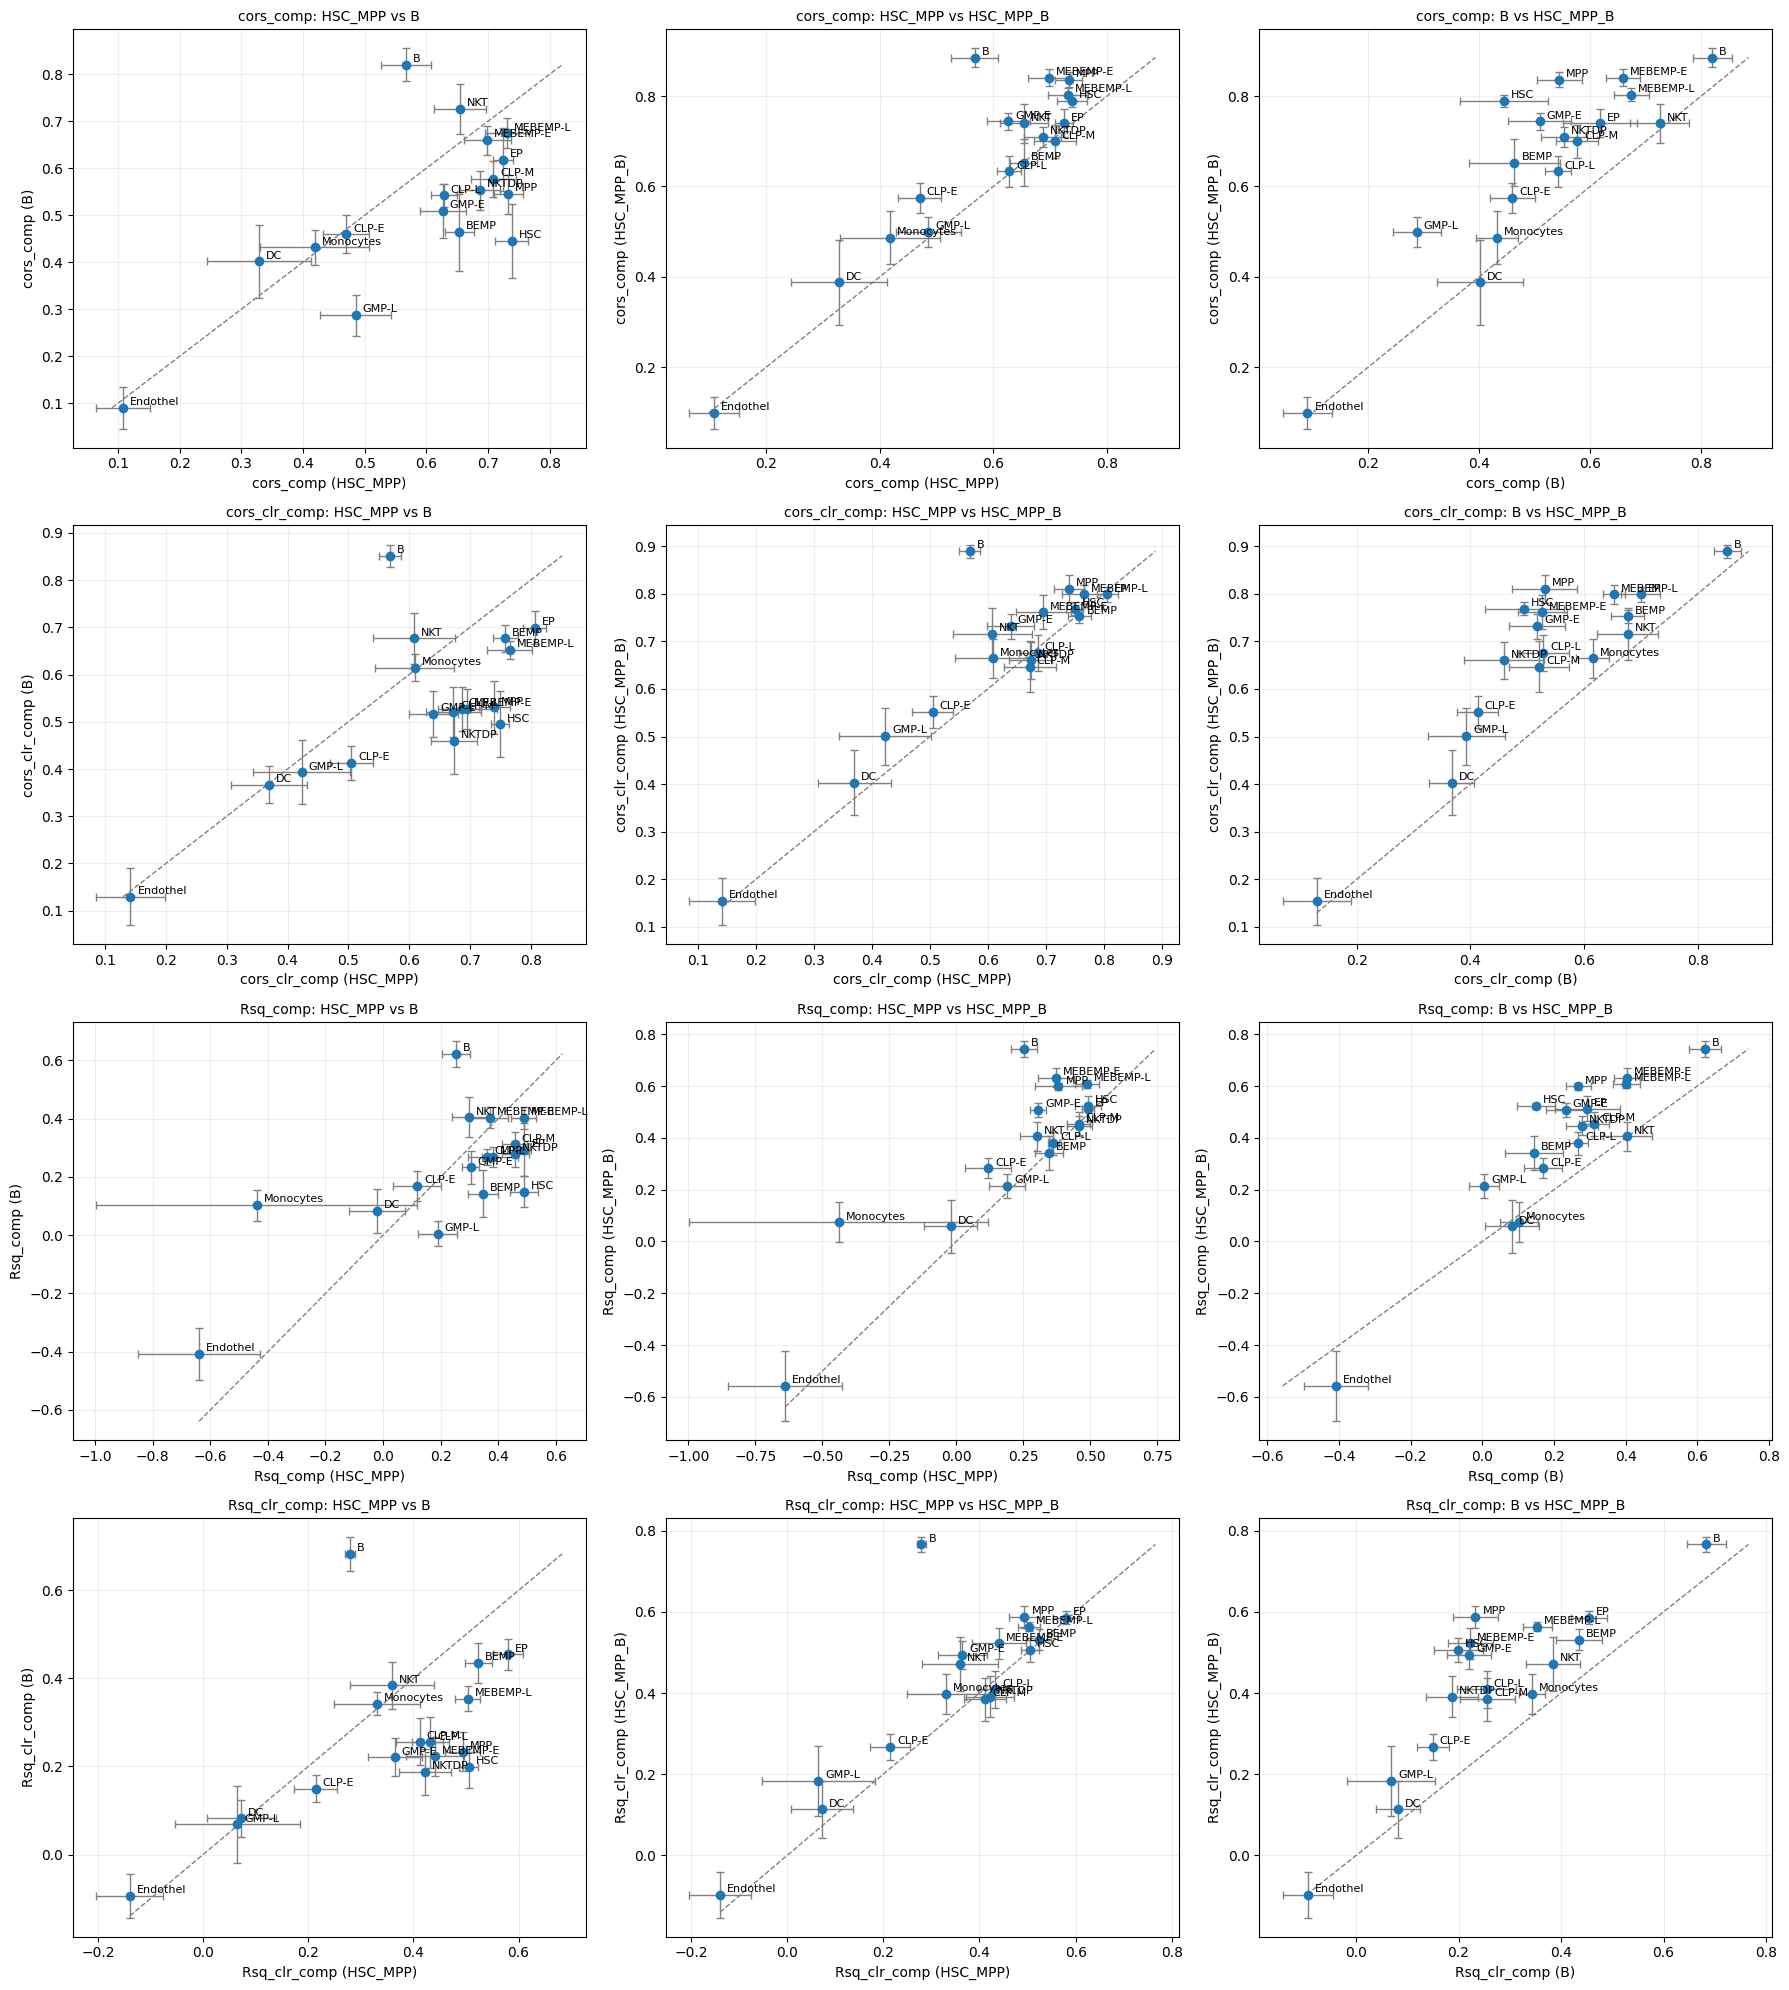

In [10]:
from regression.plotting import Plotting

Plotting = Plotting()

# Assuming you have an instance `plotter = Plotting()`
metric_name_list = ["cors_comp", "cors_clr_comp", "Rsq_comp", "Rsq_clr_comp"]

metrics_dict = {cell_type_1: metrics_by_bin_HSC, 
                cell_type_2: metrics_by_bin_B, 
                cell_type_3: metrics_by_bin_HSC_MPP_B}


fig, axes = Plotting.scatter_design_matrices(metrics_dict = metrics_dict, metric_names = metric_name_list)


## Comments

The plots show that HSC_MPP indeed carries strong signals to predict cell type proportions while terminal cells carry extra information to predict their proportion. 

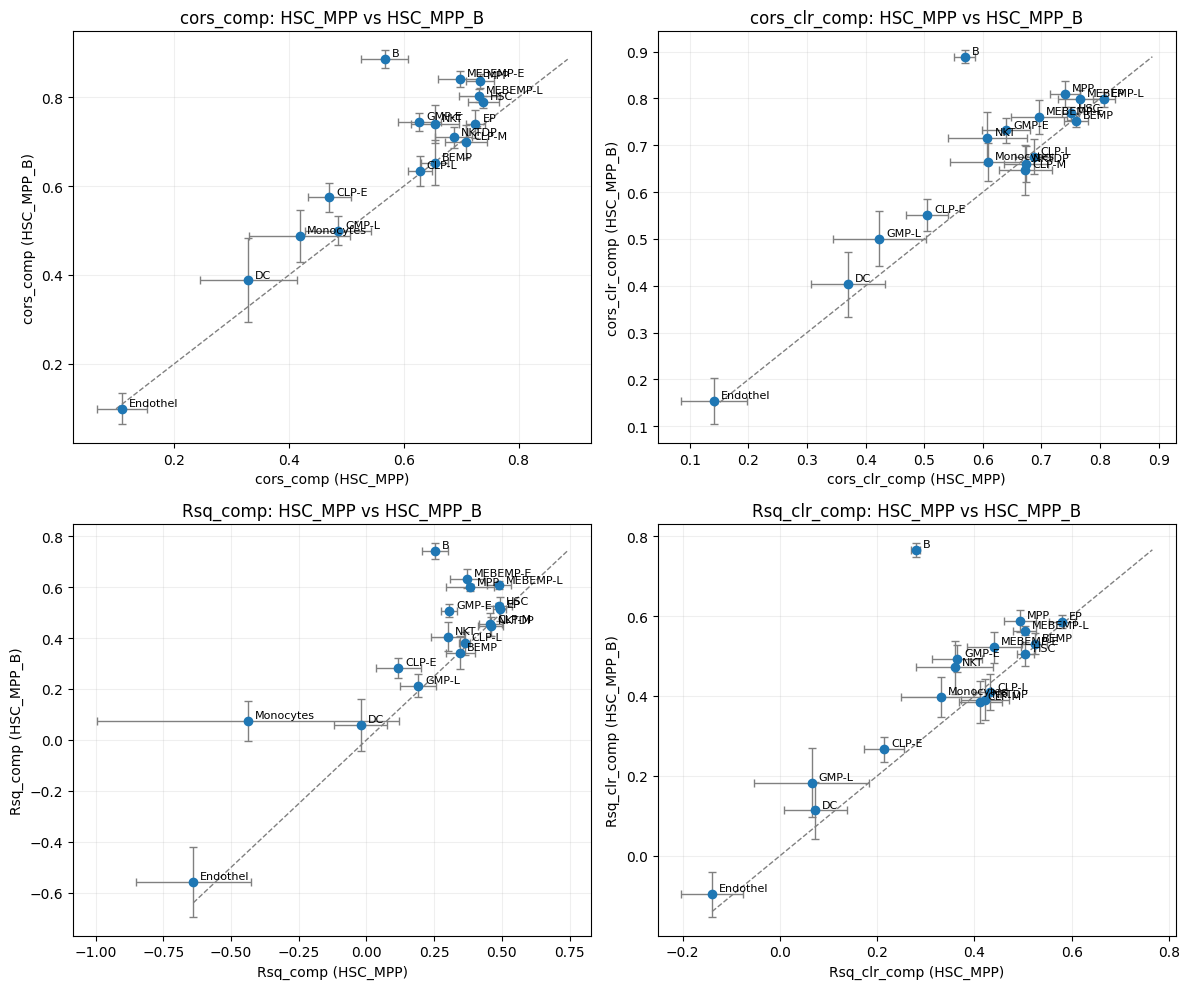

In [21]:

fig, axes = Plotting.scatter_two_celltypes_panel(
    celltype_x=cell_type_1,
    metrics_by_bin_x=metrics_by_bin_HSC,
    celltype_y=cell_type_3,
    metrics_by_bin_y=metrics_by_bin_HSC_MPP_B,
    metric_names=metric_name_list,
    ncols=2
)

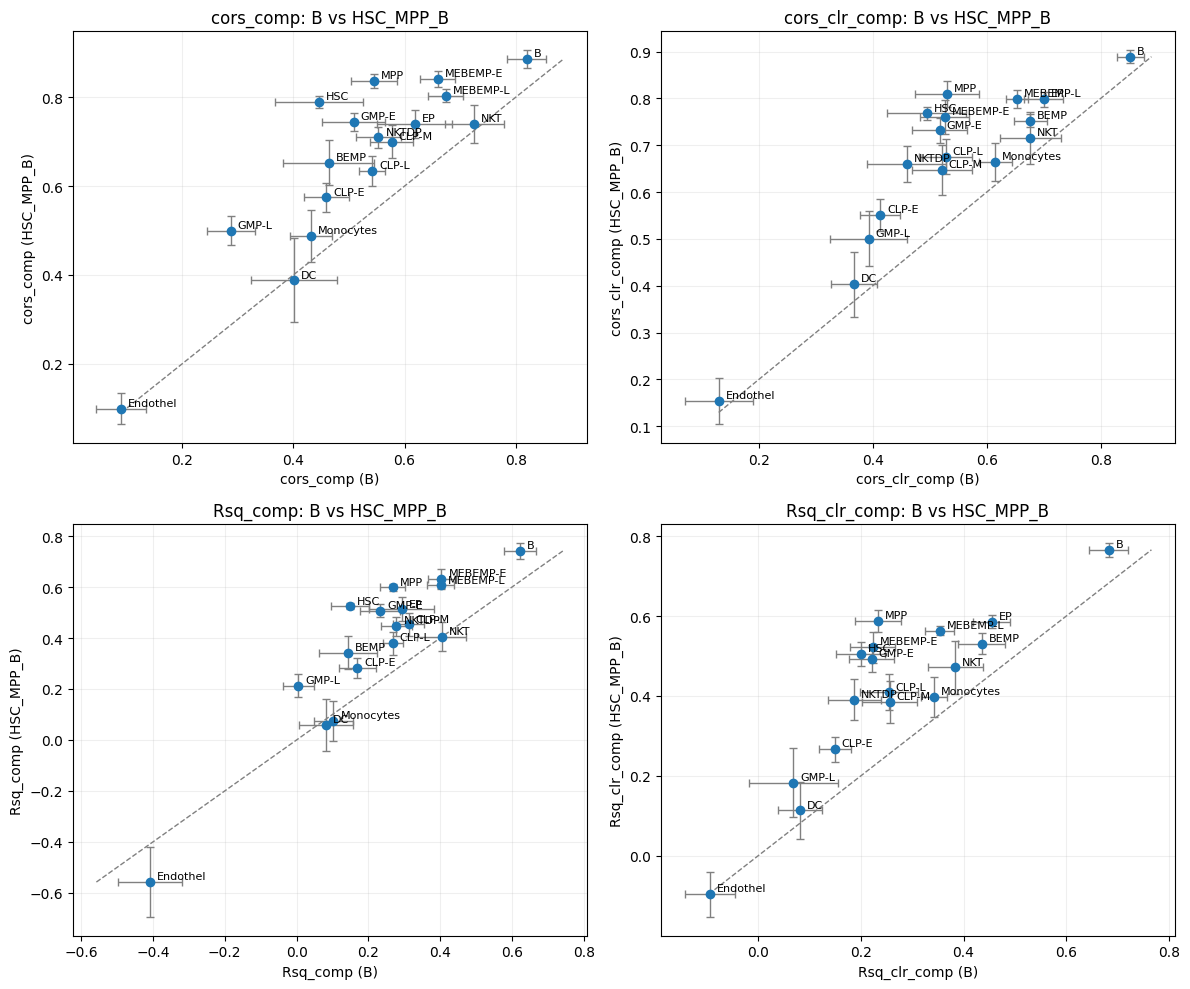

In [22]:
fig, axes = Plotting.scatter_two_celltypes_panel(
    celltype_x=cell_type_2,
    metrics_by_bin_x=metrics_by_bin_B,
    celltype_y=cell_type_3,
    metrics_by_bin_y=metrics_by_bin_HSC_MPP_B,
    metric_names=metric_name_list,
    ncols=2
)

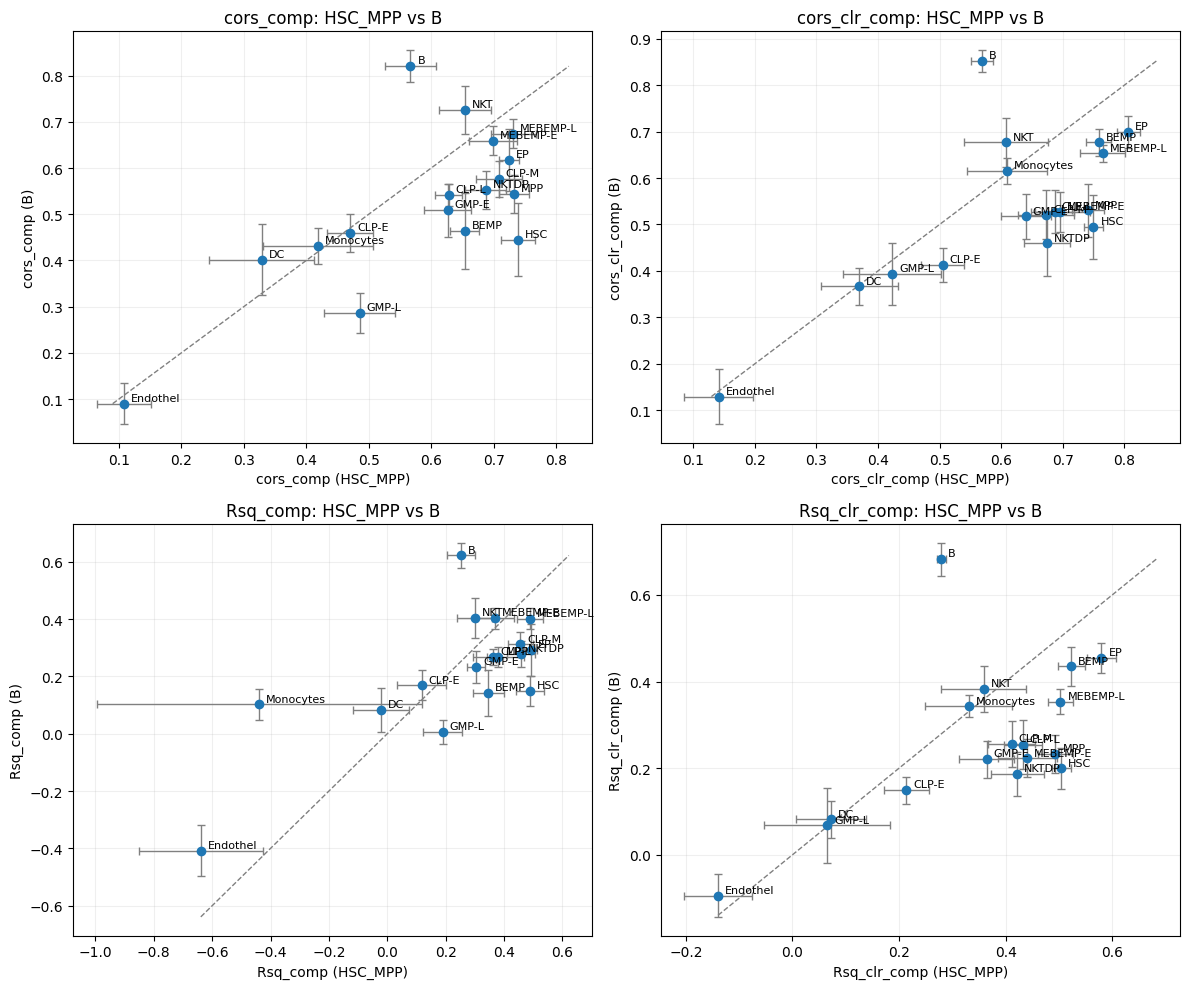

In [23]:
fig, axes = Plotting.scatter_two_celltypes_panel(
    celltype_x=cell_type_1,
    metrics_by_bin_x=metrics_by_bin_HSC,
    celltype_y=cell_type_2,
    metrics_by_bin_y=metrics_by_bin_B,
    metric_names=metric_name_list,
    ncols=2
)

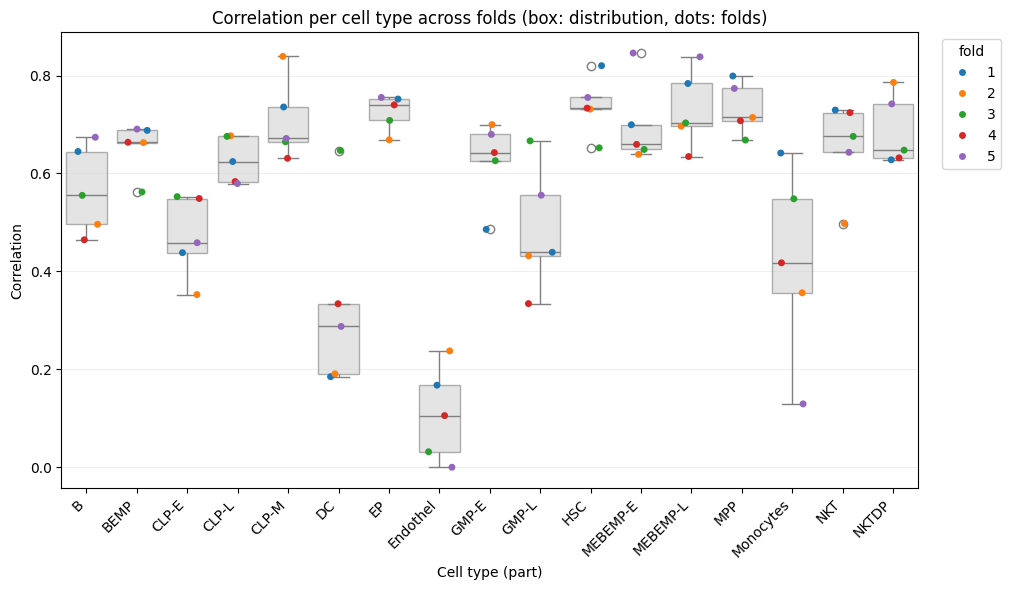

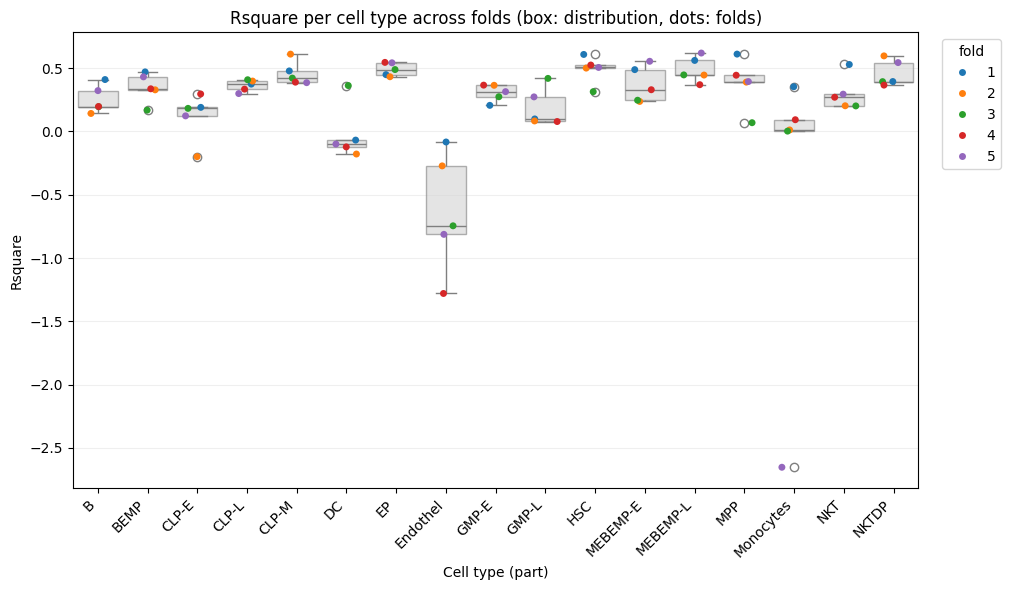

In [24]:
# Box plots with per-fold scatter for per-part metrics (corr or R^2)

fig, ax = Plotting.distribution_across_folds(metrics_by_bin_HSC, metric_name="Correlation")

fig, ax = Plotting.distribution_across_folds(metrics_by_bin_HSC, metric_name="Rsquare")


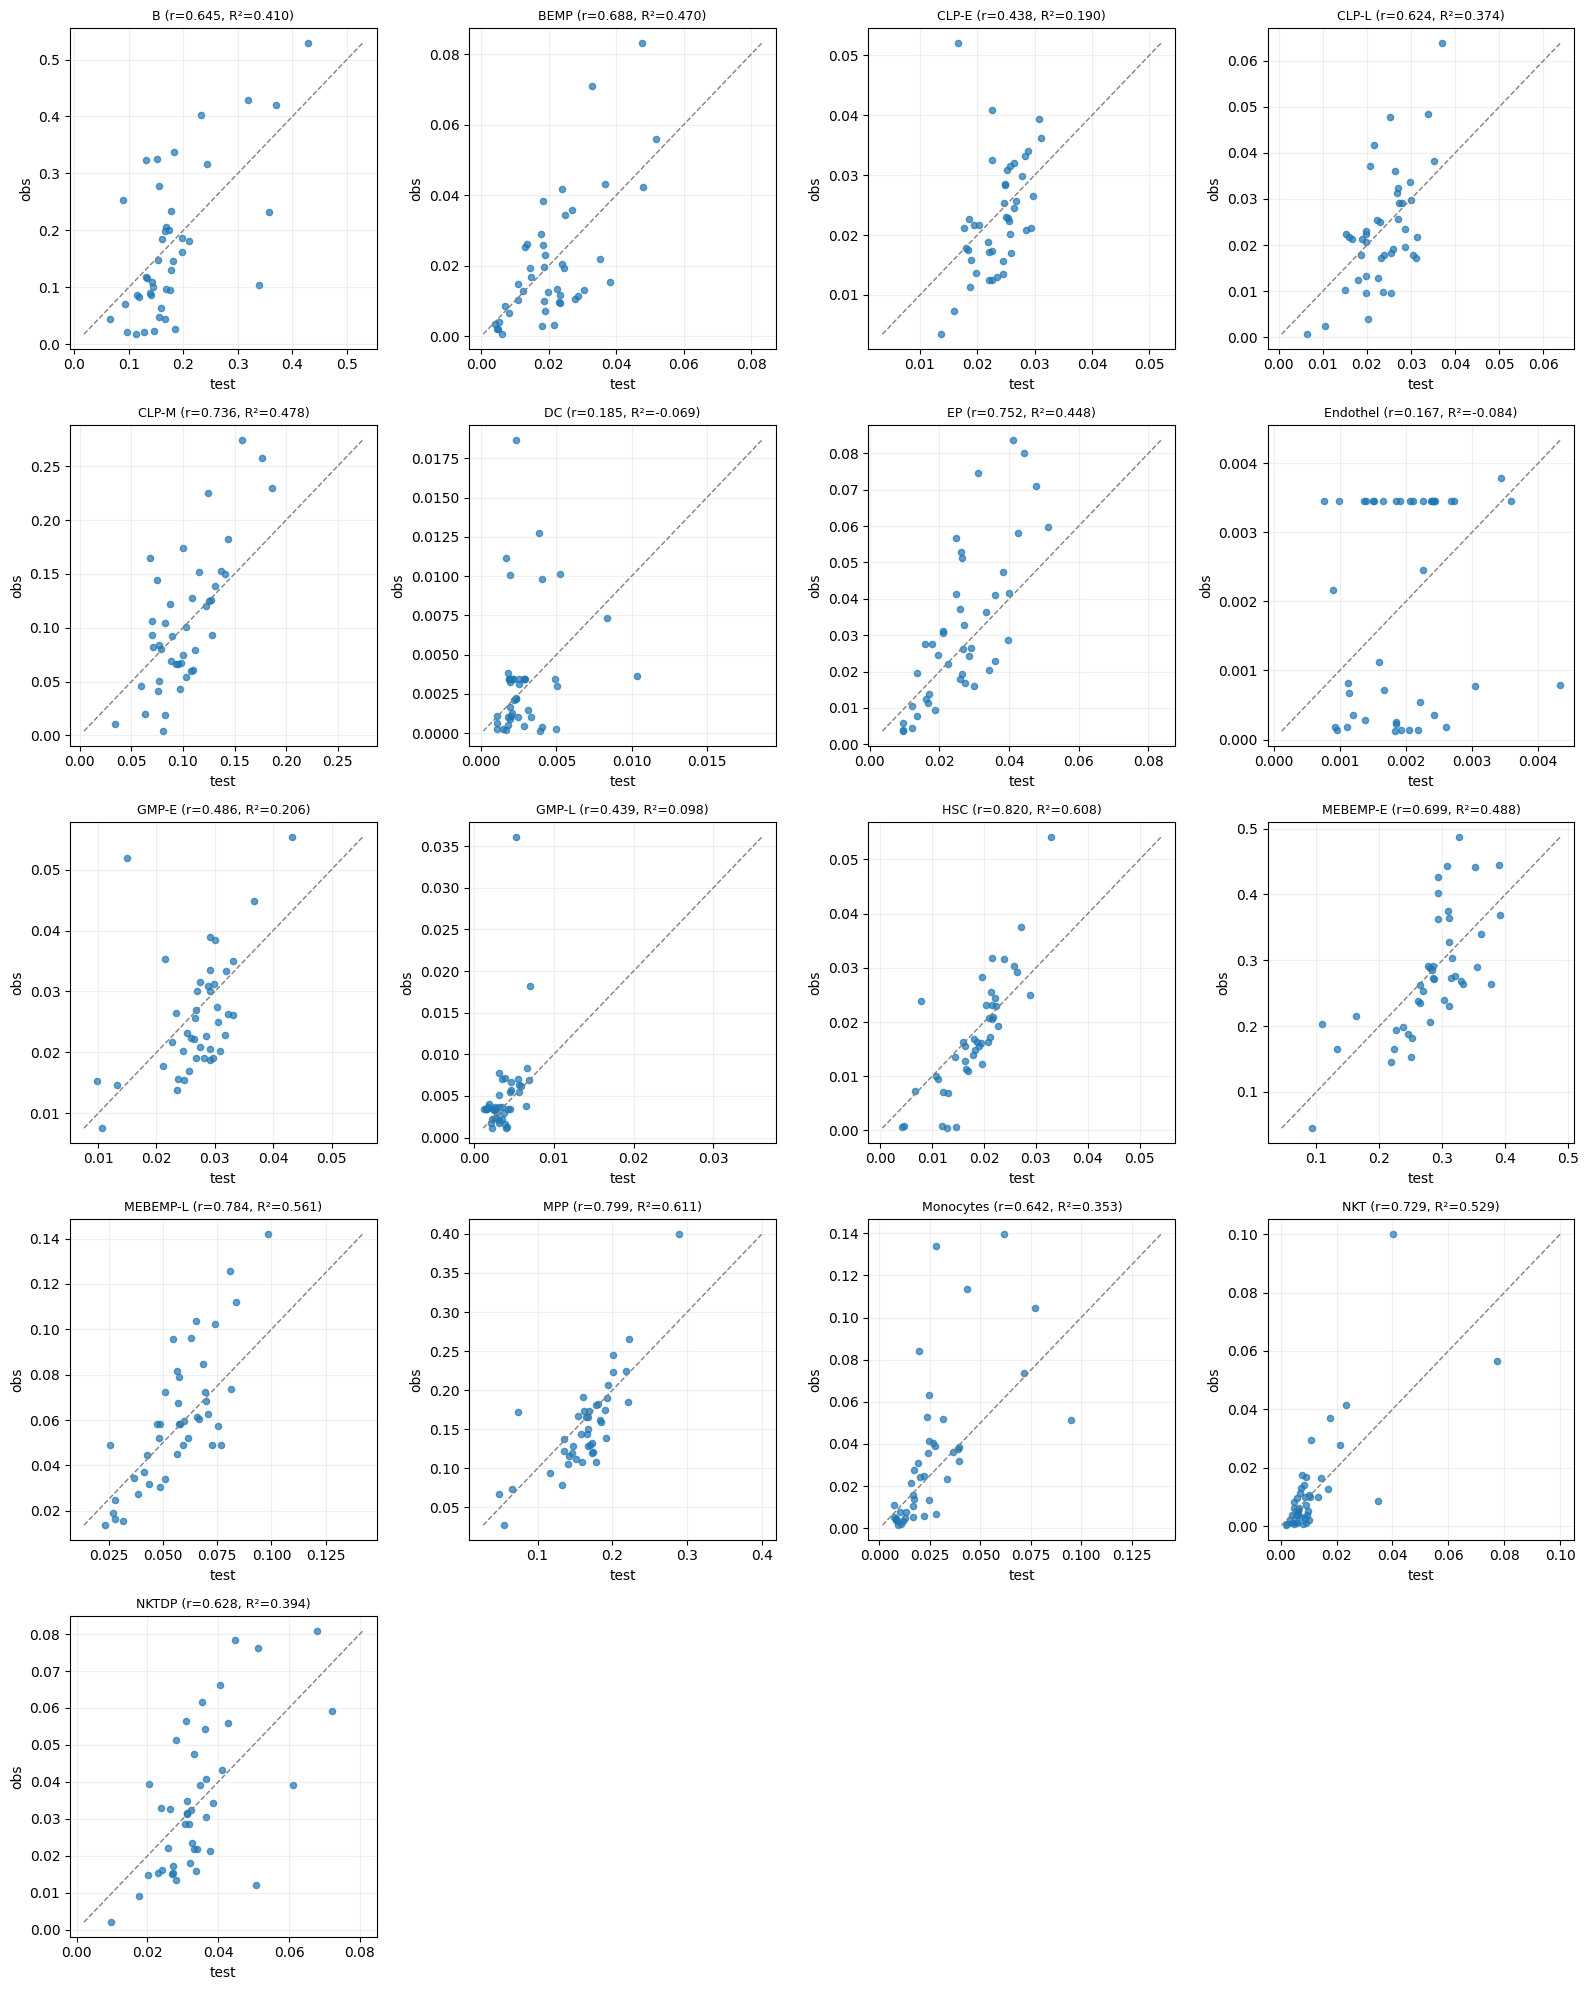

In [25]:
# Scatter grid: predicted vs observed per column, one subplot per cell type
# plot the second fold

fig, axes, metrics = Plotting.plot_test_vs_obs_grid(
    metrics_by_bin_HSC[1]["Y_test_comp_df"],
    metrics_by_bin_HSC[1]["Y_obs_comp_df"],
    ncols=4,
    title_prefix=""
)
# print(metrics)

## try min_cells filtering

Bin 1: rank=16, lambda=316.23, MSE clr comp=0.5028
Bin 2: rank=16, lambda=177.83, MSE clr comp=0.4820
Bin 3: rank=16, lambda=0.0001, MSE clr comp=0.4287
Bin 4: rank=16, lambda=0.0001, MSE clr comp=0.4547
Bin 5: rank=16, lambda=0.00031623, MSE clr comp=0.4291
Bin 1: rank=13, lambda=177.83, MSE clr comp=0.5479
Bin 2: rank=15, lambda=0.00056234, MSE clr comp=0.4646
Bin 3: rank=15, lambda=0.0001, MSE clr comp=0.3907
Bin 4: rank=15, lambda=0.0001, MSE clr comp=0.4677
Bin 5: rank=16, lambda=0.0056234, MSE clr comp=0.4260
Bin 1: rank=16, lambda=0.00056234, MSE clr comp=0.4691
Bin 2: rank=16, lambda=0.0001, MSE clr comp=0.4105
Bin 3: rank=16, lambda=0.0001, MSE clr comp=0.3501
Bin 4: rank=16, lambda=0.0001, MSE clr comp=0.3998
Bin 5: rank=16, lambda=0.0017783, MSE clr comp=0.3783


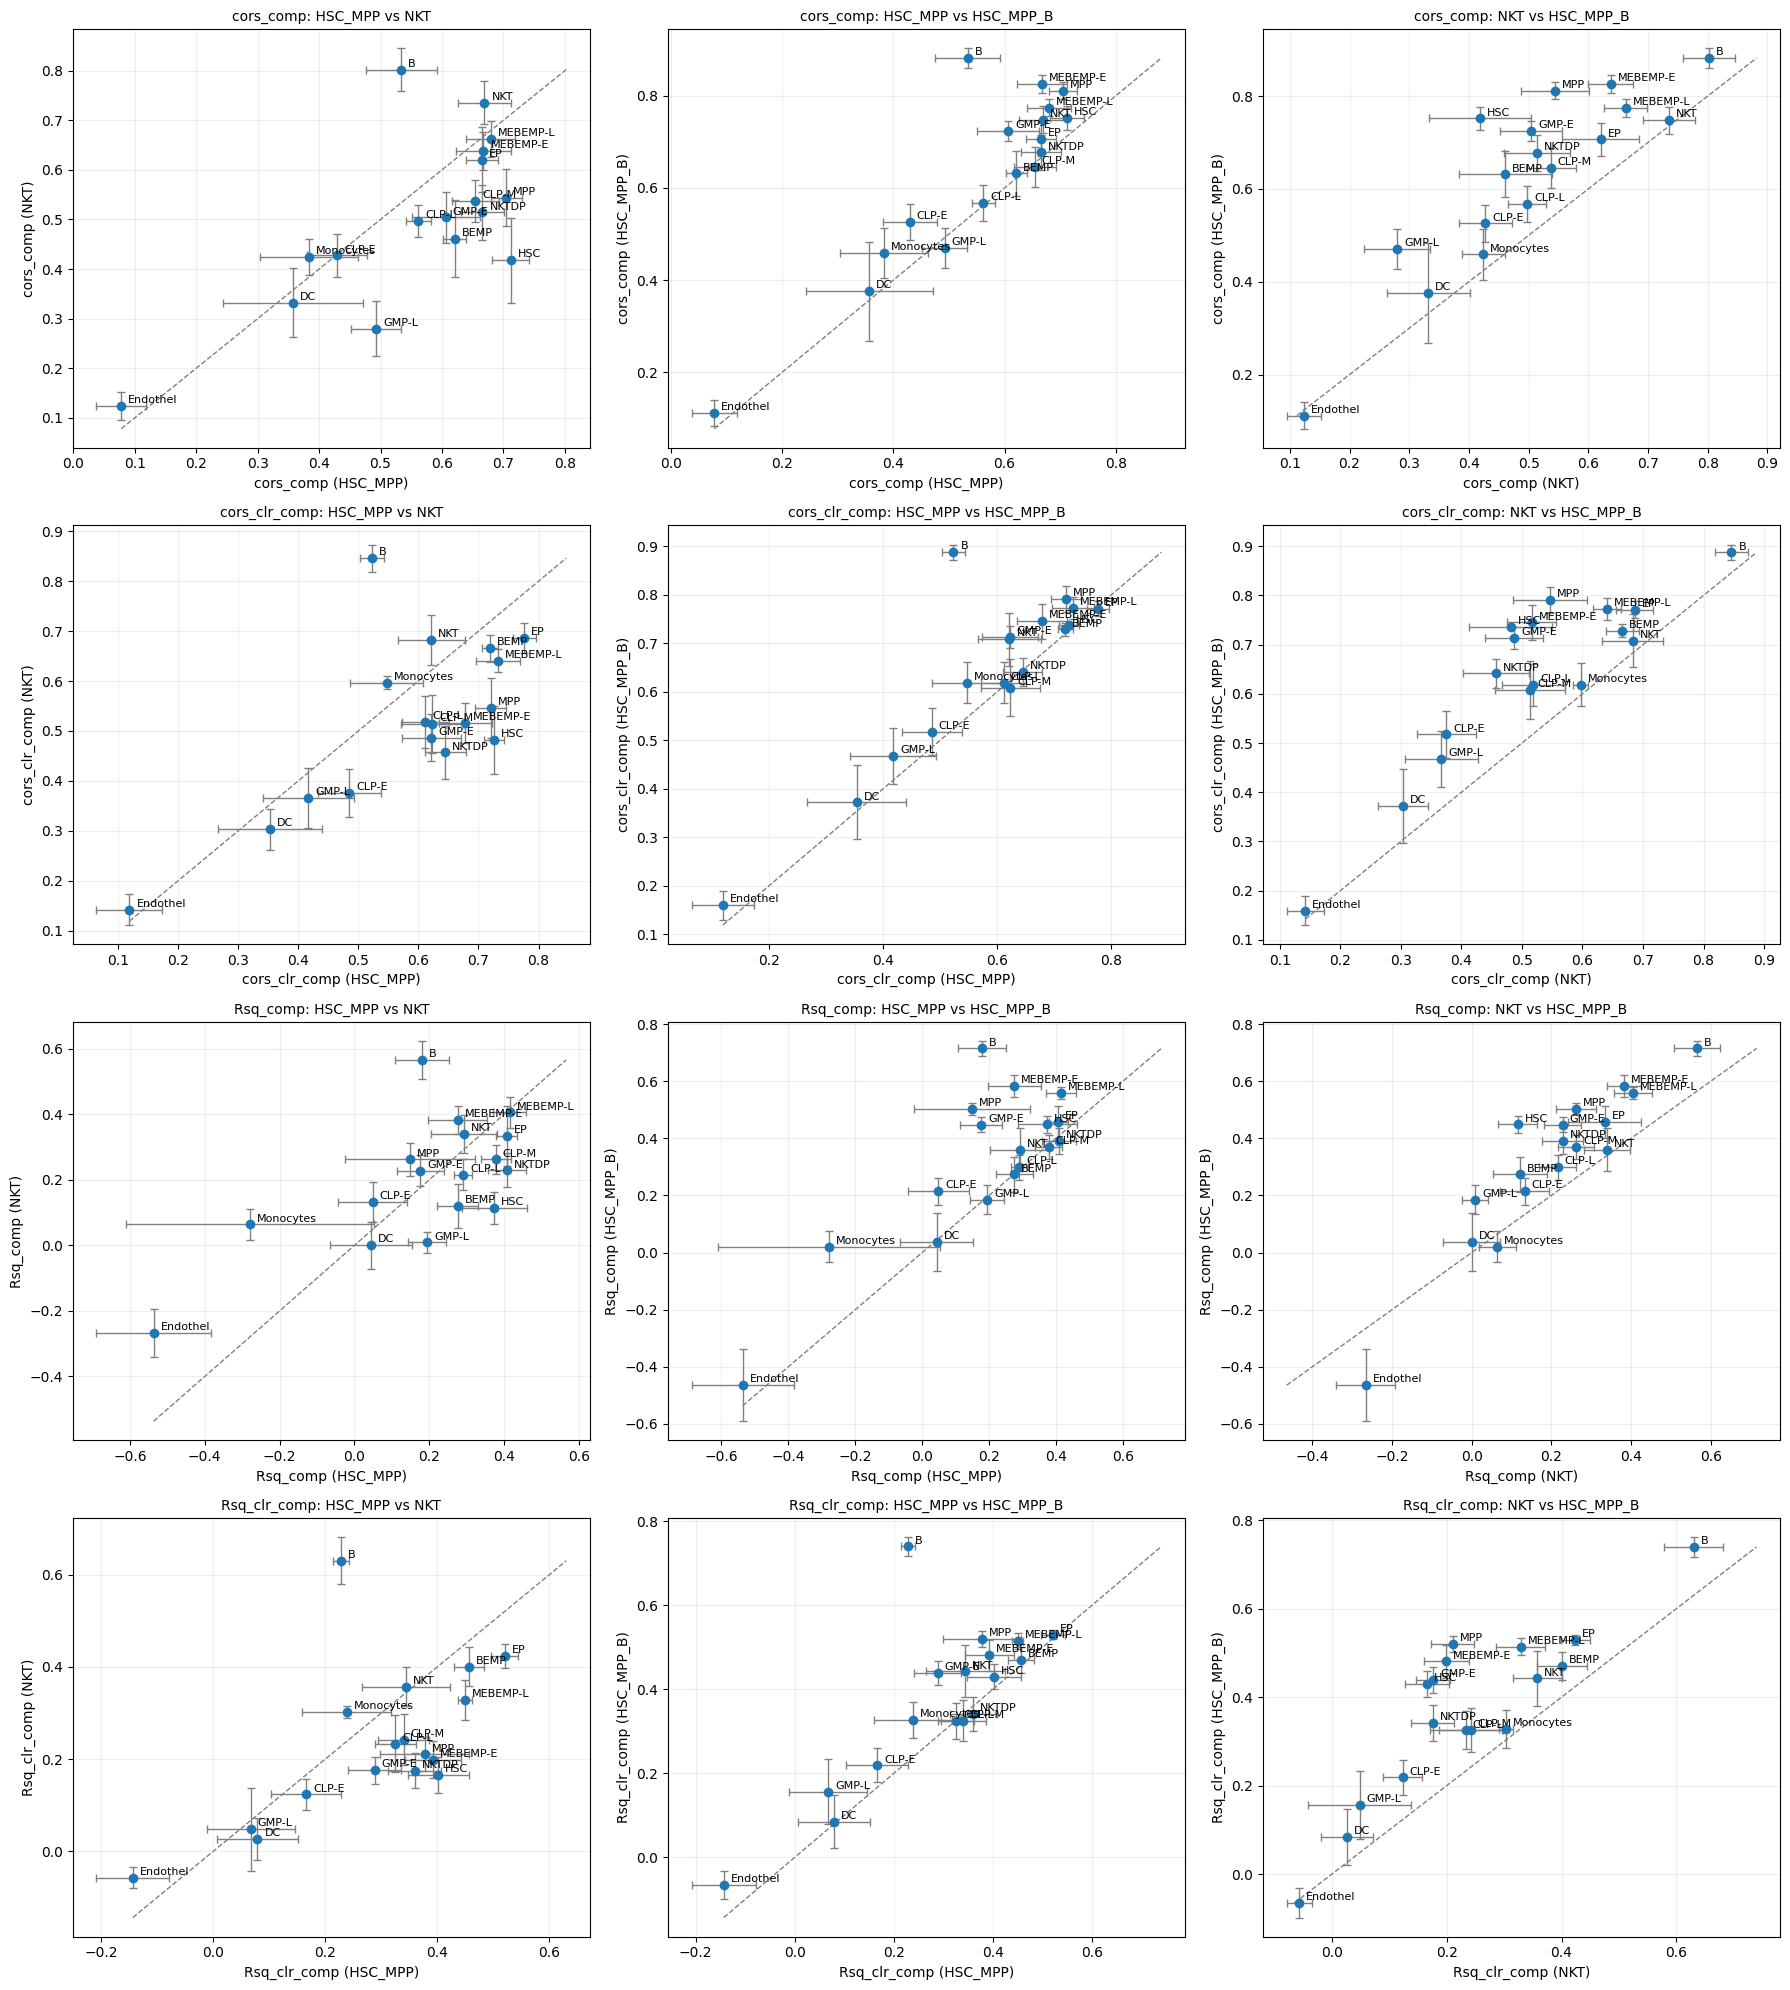

In [133]:
from regression.estimators import RidgeRRR, RidgeRRRCV
from regression.preprocessing import CompositionalILR, StandardScalerX, CenterY, TrainTestSplit
from regression.checkfitting import CheckFitting
from regression.estimators import RRRBinEvaluator
from regression.plotting import Plotting

import argparse
import os
import torch
import numpy as np
import pandas as pd
from skbio.stats.composition import closure, multiplicative_replacement, ilr, ilr_inv, clr

parser = argparse.ArgumentParser()
parser.add_argument(
    "--method",
    type=str,
    choices=["max_counts", "min_cells"],
    default="min_cells",
    help="Filtering method to use: 'max_counts' or 'min_cells' (default: min_cells)"
    )
parser.add_argument(
    "--cell_type_1",
    type=str,
    # nargs="+",  #remove to get plain string
    required=True,
    help="Celltypes to calculate, space-separated (e.g., HSC_MPP)"
    )
parser.add_argument(
    "--cell_type_2",
    type=str,
    # nargs="+",
    required=True,
    help="Celltypes to calculate, space-separated (e.g., B)"
    )
parser.add_argument(
    "--path_dir",
    type=str,
    help="Folder to store results (e.g., ../results/normal_HSC/pseudobulk/)"
    )

# Parse arguments
# args = parser.parse_args()

# checking
args = parser.parse_args([
    "--method", "min_cells",
    "--cell_type_1", "HSC_MPP",          # nargs="+": single value becomes ["HSC_MPP"]
    "--cell_type_2", "B",
    "--path_dir", "/home/lel2/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/min_cells/mean_gene_expression/"
])

# path_dir = "/home/lel2/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/min_cells/mean_gene_expression/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 1) Read CSVs; first column is an ID, so use it as index (equivalent to R's [, 2:ncol])
# cell_type_1 = "HSC_MPP"
mean_gene_expr_df_1 = pd.read_csv(
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/mean_gene_expression_harmony_sample_id.csv",
    # args.path_dir + "mean_gene_expression_pseudobulk_" + args.cell_type_1 + "_min_cells.csv",
    os.path.join(args.path_dir, f"mean_gene_expression_pseudobulk_{args.cell_type_1}_{args.method}.csv"),
    index_col=0
)

# cell_type_2 = "B"
# cell_type_2 = "NKT"

mean_gene_expr_df_2 = pd.read_csv(
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/mean_gene_expression_harmony_sample_id.csv",
    # args.path_dir + "mean_gene_expression_pseudobulk_" + args.cell_type_2 + "_min_cells.csv",
    os.path.join(args.path_dir, f"mean_gene_expression_pseudobulk_{args.cell_type_2}_{args.method}.csv"),
    index_col=0
)

cell_type_proportions_df = pd.read_csv(
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/cell_type_proportions_harmony_sample_id.csv",
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/cell_type_proportions_harmony_sample_id_avg_pseudobulk.csv",
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/max_counts/parallel/cell_type_proportions_pseudobulk_max_counts.csv",
    os.path.join(args.path_dir, f"cell_type_proportions_pseudobulk_{args.method}.csv"),
    index_col=0
)

# meta =  pd.read_csv("/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/max_counts/parallel/metadata_samples_pseudobulk_max_counts.csv")
# meta = pd.read_csv("/home/lel2/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/min_cells/mean_gene_expression/metadata_samples_pseudobulk_min_cells.csv")
meta = pd.read_csv(os.path.join(args.path_dir, f"metadata_samples_pseudobulk_{args.method}.csv"))


# check that the indices (sample IDs) are the same and in the same order
assert(np.all(mean_gene_expr_df_1.index == mean_gene_expr_df_2.index))
assert(np.all(mean_gene_expr_df_1.index == cell_type_proportions_df.index))
assert(np.all(mean_gene_expr_df_1.index == meta["sample_id"]))

# ilr-transform cell type proportions
ilr_tx = CompositionalILR(zero_replacement=True).fit(cell_type_proportions_df.values)
Y_imp_ilr = ilr_tx.transform(cell_type_proportions_df.values)  # replace your earlier line

# Covariates: sex (one-hot, drop_first) and ages
Z = pd.get_dummies(meta[['sex_src']], prefix='sex_src', drop_first=True)
Z['ages'] = meta['ages'].astype(float)
Z = Z.astype(float)
Z.index = meta.index  # align


# stem cells of HSC_MPP and B cells
# X_design = np.concatenate([mean_gene_expr_df_HSC_MPP.values.astype(np.float64),
#                            mean_gene_expr_df_B.values.astype(np.float64),
#                            Z.to_numpy()], axis=1)

# generate bins
train_test = TrainTestSplit(nfolds = 5, random_state = 0)

# cell_type_1
f"Doing regression on {cell_type_1}"
X_design_1 = np.concatenate([mean_gene_expr_df_1.values.astype(np.float64),
                             Z.to_numpy()], axis=1)

RRRB_1 = RRRBinEvaluator(device)
metrics_by_bin_1 = RRRB_1.evaluate(X_design = X_design_1,
                                       Y_ilr = Y_imp_ilr, 
                                       train_test = train_test,
                                       ilr_tx = ilr_tx,
                                       cell_type_proportions_df = cell_type_proportions_df)

# cell_type_2
f"Doing regression on {cell_type_2}"
X_design_2 = np.concatenate([mean_gene_expr_df_2.values.astype(np.float64),
                             Z.to_numpy()], axis=1)

RRRB_2 = RRRBinEvaluator(device)
metrics_by_bin_2 = RRRB_2.evaluate(X_design = X_design_2,
                                   Y_ilr = Y_imp_ilr, 
                                   train_test = train_test,
                                   ilr_tx = ilr_tx,
                                   cell_type_proportions_df = cell_type_proportions_df)

# cell_type_1 + cell_type_2
cell_type_1_2 = args.cell_type_1 + "_" + args.cell_type_2
f"Doing regression on {cell_type_1_2}"

X_design_1_2 = np.concatenate([mean_gene_expr_df_1.values.astype(np.float64),
                             mean_gene_expr_df_2.values.astype(np.float64),
                             Z.to_numpy()], axis=1)


RRRB_1_2 = RRRBinEvaluator(device)
metrics_by_bin_1_2 = RRRB_1_2.evaluate(X_design = X_design_1_2,
                                           Y_ilr = Y_imp_ilr, 
                                           train_test = train_test,
                                           ilr_tx = ilr_tx,
                                           cell_type_proportions_df = cell_type_proportions_df)


f"Plotting"

Plotting = Plotting()

# Assuming you have an instance `plotter = Plotting()`
metric_name_list = ["cors_comp", "cors_clr_comp", "Rsq_comp", "Rsq_clr_comp"]

metrics_dict = {cell_type_1: metrics_by_bin_1, 
                cell_type_2: metrics_by_bin_2, 
                cell_type_1_2: metrics_by_bin_1_2}


fig, axes = Plotting.scatter_design_matrices(metrics_dict = metrics_dict, metric_names = metric_name_list)

plot_dir = args.path_dir + "plots/"
os.makedirs(plot_dir, exist_ok = True)
file_path = os.path.join(plot_dir, f"{cell_type_1_2}.pdf")
fig.savefig(file_path, format = "pdf", bbox_inches = "tight")






## try max_counts

In [ ]:

from regression.estimators import RidgeRRR, RidgeRRRCV, RRRBinEvaluator
from regression.preprocessing import CompositionalILR, StandardScalerX, CenterY, TrainTestSplit
from regression.checkfitting import CheckFitting

import torch
import numpy as np
import pandas as pd
from skbio.stats.composition import closure, multiplicative_replacement, ilr, ilr_inv, clr

path_dir = "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/max_counts/parallel/mean_gene_expression_pseudobulk_"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 1) Read CSVs; first column is an ID, so use it as index (equivalent to R's [, 2:ncol])
cell_type_1 = "HSC_MPP"

mean_gene_expr_df_HSC_MPP = pd.read_csv(
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/mean_gene_expression_harmony_sample_id.csv",
    path_dir + cell_type_1 + "_max_counts.csv",
    index_col=0
)

cell_type_2 = "B"
# cell_type_2 = "NKT"

mean_gene_expr_df_B = pd.read_csv(
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/mean_gene_expression_harmony_sample_id.csv",
    path_dir + cell_type_2 + "_max_counts.csv",
    index_col=0
)

cell_type_proportions_df = pd.read_csv(
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/cell_type_proportions_harmony_sample_id.csv",
    # "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/cell_type_proportions_harmony_sample_id_avg_pseudobulk.csv",
    "/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/max_counts/parallel/cell_type_proportions_pseudobulk_max_counts.csv",
    index_col=0
)

meta =  pd.read_csv("/data1/soldatr/luan/projects/cell_tissue_phenotype/results/normal_HSC/pseudobulk/max_counts/parallel/metadata_samples_pseudobulk_max_counts.csv")

# check that the indices (sample IDs) are the same and in the same order
assert(np.all(mean_gene_expr_df_HSC_MPP.index == mean_gene_expr_df_B.index))
assert(np.all(mean_gene_expr_df_HSC_MPP.index == cell_type_proportions_df.index))
assert(np.all(mean_gene_expr_df_HSC_MPP.index == meta["sample_id"]))

# ilr-transform cell type proportions
ilr_tx = CompositionalILR(zero_replacement=True).fit(cell_type_proportions_df.values)
Y_imp_ilr = ilr_tx.transform(cell_type_proportions_df.values)  # replace your earlier line

# Covariates: sex (one-hot, drop_first) and ages
Z = pd.get_dummies(meta[['sex_src']], prefix='sex_src', drop_first=True)
Z['ages'] = meta['ages'].astype(float)
Z = Z.astype(float)
Z.index = meta.index  # align


# stem cells of HSC_MPP and B cells
# X_design = np.concatenate([mean_gene_expr_df_HSC_MPP.values.astype(np.float64),
#                            mean_gene_expr_df_B.values.astype(np.float64),
#                            Z.to_numpy()], axis=1)

# generate bins
train_test = TrainTestSplit(nfolds = 5, random_state = 0)





# try other stuffs

In [ ]:
# try other stuffs

# check similarity between two matrices 
import sas

similarity = sas.compare(mean_gene_expr_df_HSC_MPP.to_numpy(), mean_gene_expr_df_B.to_numpy())

# do PCA

X = mean_gene_expr_df_HSC_MPP.to_numpy()

X_train, X_pred, Y_train, Y_pred = train_test.split(X, Y_imp_ilr, fold = 1)
X_train, X_pred = train_test.filter_feature(X_train = X_train, X_pred = X_pred)

def do_PCA(X, X_center = None, X_std = None):
    if np.all(X_center == None) & np.all(X_std == None):
        X_center = X.mean(axis = 0, keepdims = True)
        X_std = X.std(axis = 0, keepdims = True)
        
    #center and scale columns
    Xs = (X - X_center)/X_std

    #do SVD
    U, S, Vt = np.linalg.svd(Xs, full_matrices = False)

    #PC scores
    PC_scores = U * S

    #loadings
    loadings = Vt

    #check variance explained
    explained_var = (S**2)/(X.shape[0] - 1)
    explained_ratio = explained_var / explained_var.sum()

    return PC_scores, loadings, S, explained_ratio

# get PCS
PC_scores_train, loadings_train, S_train, explained_ratio_train = do_PCA(X_train)
PC_scores_pred, loadings_pred, S_pred, explained_ratio_pred = do_PCA(X_pred, 
                                                                     X_center = X_train.mean(axis = 0, keepdims = True),
                                                                     X_std = X_train.std(axis = 0, keepdims = True))

threshold = 0.7
n_PCs = np.where(np.cumsum(explained_ratio_train) >= threshold)[0][0]

if n_PCs > PC_scores_pred.shape[1]:
    n_PCs = PC_scores_pred.shape[1]


# a = np.cumsum(explained_ratio_train) >= 0.7
# n_PCs = np.where(np.cumsum(explained_ratio_train) >= 0.7)[0][0]

np.cumsum(explained_ratio_train)[n_PCs]

# # regress on PCs

# PC_scores_train = PC_scores_train[:, :n_PCs]
# PC_scores_pred = PC_scores_pred[:, :n_PCs]

# X_design = np.concatenate([PC_scores_train, PC_scores_pred], axis = 0)
# X_design_HSC_MPP = np.concatenate([X_design, Z.to_numpy()], axis = 1)

In [ ]:
fold = 1
# extract coef matrix B
B = metrics_by_bin_HSC[fold]['cv'].best_estimator_.coef_.cpu()

# correspoding feature names in matrix B
features_names = np.array(mean_gene_expr_df_HSC_MPP.columns.tolist() + Z.columns.tolist())
keep_mask = metrics_by_bin_HSC[fold]['keep_mask']
features_names = features_names[keep_mask]

# index of features
j = 10
b_j = B[:, j]

coef_imp = pd.Series(np.abs(b_j), index = features_names
coef_imp = coef_imp.sort_values(ascending = False)


genes_fold = {}
n_topgenes = 20000

for fold in range(1, 6):
    # fold = 1
    # extract coef matrix B
    B = metrics_by_bin_HSC_MPP_B[fold]['cv'].best_estimator_.coef_.cpu()

    # correspoding feature names in matrix B
    features_names = np.array(mean_gene_expr_df_HSC_MPP.columns.tolist() + [gene_name + "_B" for gene_name in mean_gene_expr_df_B.columns.tolist()] + Z.columns.tolist())
    keep_mask = metrics_by_bin_HSC_MPP_B[fold]['keep_mask']
    features_names = features_names[keep_mask]

    # index of features
    j = 0 # correspond to B
    b_j = B[:, j]
    
    coef_imp = pd.Series(np.abs(b_j), index = features_names)
    coef_imp = coef_imp.sort_values(ascending = False)
    
    top_genes = np.array(coef_imp.index.tolist()[:n_topgenes])
    top_genes_extra = np.char.endswith(top_genes, "_B")
    genes = top_genes[np.where(top_genes_extra)[0]]
    genes_fold[fold] = genes

common_genes = set.intersection(*(set(g) for g in genes_fold.values()))

common_genes = list(common_genes)
common_genes = np.char.rstrip(common_genes, "_B")

print([len(g) for g in genes_fold.values()])
len(common_genes)

In [ ]:
# gene sets enrichment

import gseapy as gp

enr = gp.enrichr(
    gene_list=list(common_genes),
    gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human'],
    organism='Human'
)
# Filter for B-cell-related pathways
b_related = enr.results[enr.results['Term'].str.contains('B cell', case=False)]

enr_sorted = enr.results.sort_values(by = "Adjusted P-value", ascending = True)
enr_sorted.loc[enr_sorted['Adjusted P-value'] <= 0.25]